# 1. Qu'est-ce que l'apprentissage par renforcement ?

Il s'agit d'une approche d'apprentissage automatique qui ne nécessite pas la connaissance explicite d'un modèle (sous forme d'équations). L'apprentissage par renforcement, comme l'apprentissage automatique, n'est pas nouveau : il date de la seconde moitié du XXème siècle et plus intensément à partir des années 1980.

Ce cours est largement basé sur **Reinforcement Learning: an introduction** de Sutton et Barto.

## 1.1. Tout est question d'états, d'actions et de récompenses

Les trois concepts centraux en apprentissage par renforcement sont :
* **L'état**. Dans quelle situation suis-je actuellement ?
* **L'action**. Quelle est la décision que je prends à cet instant. Celle-ci influence généralement l'état dans lequel je vais me retrouver ensuite.
* **La récompense**. Certaines situations m'amènenent une récompense, ou bien une pénalité (qui n'est autre qu'une récompense négative).

Prenons un exemple : *un enfant apprend à marcher*. A un instant donné, il est à quatre pattes, puis se lève. Son état est alors "debout". Il décide d'avancer un pied et reste debout. Il est content, ce qui correspond à une récompense positive. S'il calcule mal son coup et tombe, on peut voir cela comme une pénalité. Au bout d'un moment, cet enchainement d'états, d'actions et de récompenses l'amène à apprendre à marcher correctement. Implicitement, il cherche à maximiser ses récompenses (cognitives). Il développe ainsi ce que l'on appellera une **stratégie**.

# 2. Bandits manchots

On appelle couramment un bandit manchot (*multi-arm bandit*) une machine à sous. Chaque machine à sous suit une loi de probabilité des récompenses qui peut être différente d'une machine à l'autre.

Supposons que vous ayez devant vous **n bandits manchots et que vous puissiez choisir à chaque instant lequel actionner.** La question est de savoir **lequel actionner à chaque instant**.

**Créez une fonction qui prend un nombre de bandits manchots n en entrée et rend la récompense moyenne du bandit pour chacun d'entre eux (soit une liste de n nombre aléatoires suivant une loi normale centrée réduite).**

In [1]:
import numpy as np

In [2]:
def pick_average_values(n, seed=None):
    """Gives back n normally distributed values
    """
    if seed:
        np.random.seed(seed)
    return np.random.normal(size=n)

**Affichez ces dix valeurs sur un graphique.**

In [3]:
import matplotlib.pyplot as plt

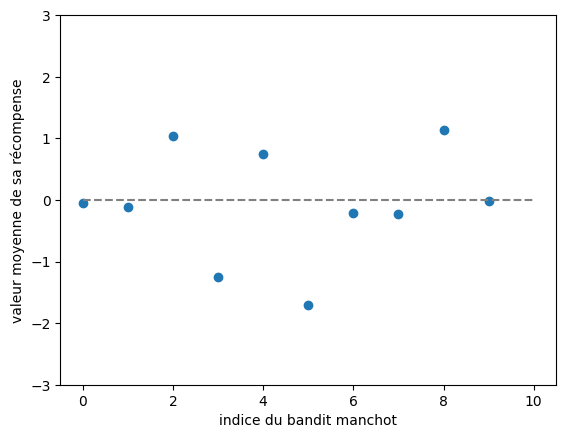

In [4]:
avgs = pick_average_values(10, seed=21)

fig, ax = plt.subplots(1, 1)
ax.scatter(range(len(avgs)), avgs)
ax.set_ylim(-3, 3)
ax.hlines(0, 0, len(avgs), linestyles="--", color="grey")
ax.set(
    xlabel="indice du bandit manchot",
    ylabel="valeur moyenne de sa récompense"
)
plt.show()

Le **bandit optimal** semble être le numéro 8, suivi du 2 puis du 4.

Comment apprendre à une machine à le trouver ?

## 2.1. Méthode "action-value"

La première méthode qui vient probablement à l'esprit est d'essayer, à chaque instant, le bandit manchot qui m'a donné pour le moment, en moyenne, la meilleure récompense.

Pour cela, on peut garder en mémoire l'historique de nos actions et de nos récompenses dans un `pd.DataFrame` que l'on appellera `mem`.

In [5]:
import pandas as pd

**Créez une fonction qui va initialiser un DataFrame en tirant tous les bandits manchots une fois.** Cette fonction prend en entrée la liste des valeurs moyennes des bandits.

Le DataFrame doit avoir **deux colonnes : "action" qui vaut entre 0 et 9 et "reward" qui est la récompense**. La récompense de la machine $i$ soit une loi normale centrée en $avgs(i)$, de variance $1$.

In [6]:
def init_mem(avgs):
    """Initializes our training by testing every bandit once
    """
    # Take every possible action
    actions = range(len(avgs))
    
    return pd.DataFrame({
        "action": actions,
        "reward": np.random.normal(loc=avgs)
    })

mem = init_mem(avgs)

mem

,action,reward
0,0,-0.665165
1,1,1.262492
2,2,2.652789
3,3,-1.945968
4,4,1.437311
5,5,-2.159169
6,6,-0.043522
7,7,0.022658
8,8,-0.147312
9,9,0.051378


Comme vous pouvez l'observer, **l'action 8 n'est naturellement pas forcément la meilleure, mais elle le sera en moyenne**.

**Créez une fonction qui, à partir d'une mémoire donnée (sous la forme d'un DataFrame), sélectionne la meilleure action à prendre**.

In [7]:
def best_action(mem: pd.DataFrame) -> int:
    """Finds best action among all possible found in the df's action column.
    """
    # Create a series that contains the mean reward up-to-now for this action
    st = mem.groupby("action")["reward"].mean()
    
    return int(st.idxmax())

best_action(mem)

2

C'est bien cette action qui était la meilleure.

**Créez une fonction `reward` qui prend en entrée la liste des valeurs moyennes des bandits ainsi qu'une action, et qui rend une récompense, tirée selon la loi normale réduite centrée en la valeur moyenne du bandit choisi.**

In [8]:
def reward(action: int, avgs: list[float]) -> float:
    """Returns a reward for the selected bandit.
    """
    return np.random.normal(loc=avgs[action])

reward(best_action(mem), avgs)

-0.020059819153792846

Même si on a choisi l'action qui nous paraissait optimale, étant donné que celle-ci est **basée sur une mémoire finie**, on peut être déçu par le résultat...

**Après avoir initialisé une mémoire, créez une boucle qui va consister à:**
* Sélectionner une action basée sur votre mémoire actuelle,
* Evaluer la récompense associée,
* Mettre à jour votre mémoire,
* Rejouer.

**Arrêtez vous au bout de 1000 essais** et comptez combien de fois vous avez choisi l'action optimale, ainsi que la moyenne sur les 10 derniers coups de votre stratégie.

In [17]:
nb = 1000

# Initialize memory
mem = init_mem(avgs)

# list of actions
actions = []

for i in range(nb):
    
    # Select best action
    a = best_action(mem)
    actions.append(a)
    
    # Evaluate reward
    r = reward(a, avgs)
    
    # Update memory
    mem = pd.concat(
        [
            mem,
            pd.DataFrame({
                "action": [a],
                "reward": [r]
            })
        ], ignore_index=True
    )

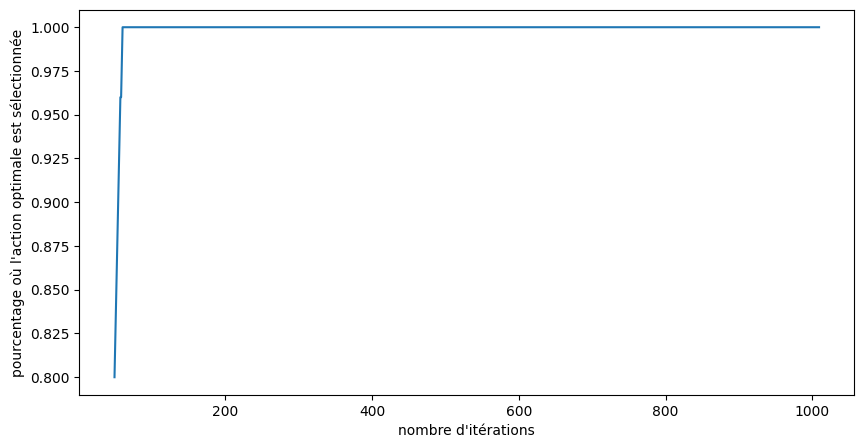

In [18]:
def plot_optimal_action(actions, avgs, window=50):
    """Plots how often the optimal action is selected."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    (pd.Series(actions) == avgs.argmax()).rolling(window=window).mean().plot(ax=ax)

    ax.set(
        xlabel="nombre d'itérations",
        ylabel="pourcentage où l'action optimale est sélectionnée"
    )
    
    return

plot_optimal_action(mem.action, avgs)

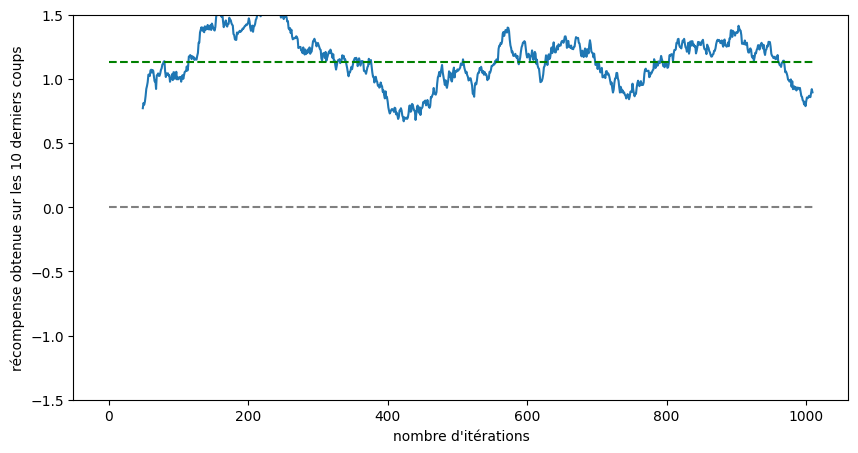

In [19]:
def plot_reward(rewards, avgs, window=50):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    pd.Series(rewards).rolling(window=window).mean().plot(ax=ax)

    ax.set(
        xlabel="nombre d'itérations",
        ylabel="récompense obtenue sur les 10 derniers coups"
    )
    
    ax.set_ylim(-1.5, 1.5)
    
    ax.hlines(0, 0, len(rewards), linestyles="--", color="grey")
    ax.hlines(max(avgs), 0, len(rewards), linestyles="--", color="green")
    
    return

plot_reward(mem.reward, avgs)

On voit qu'évidemment l'algorithme va rapidement être "bloqué" sur une action, du fait qu'**il ne prend pas le temps de suffisamment tester les autres**.

## 2.2. Stratégie epsilon-greedy

Nous allons donc imposer que régulièrement l'algorithme continue de visiter **au hasard les autres actions que celle qui semble optimale à ce stade**.

**Ré-écrivez la boucle d'apprentissage en imposant qu'une fois sur 10 l'algorithme choisisse ses actions au hasard**.

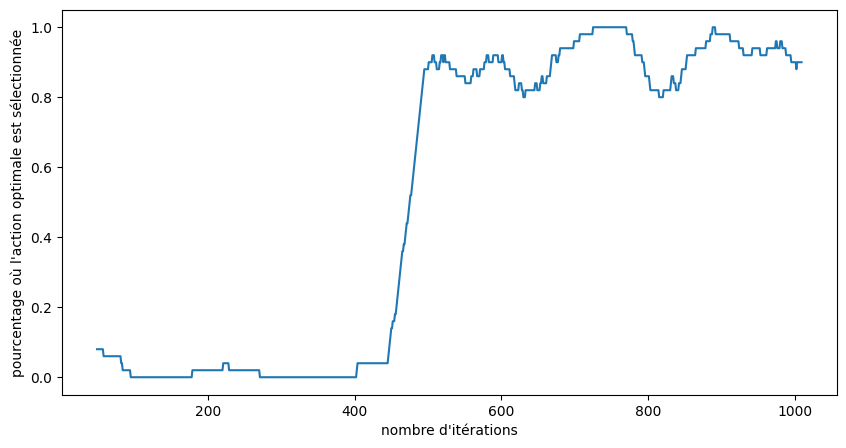

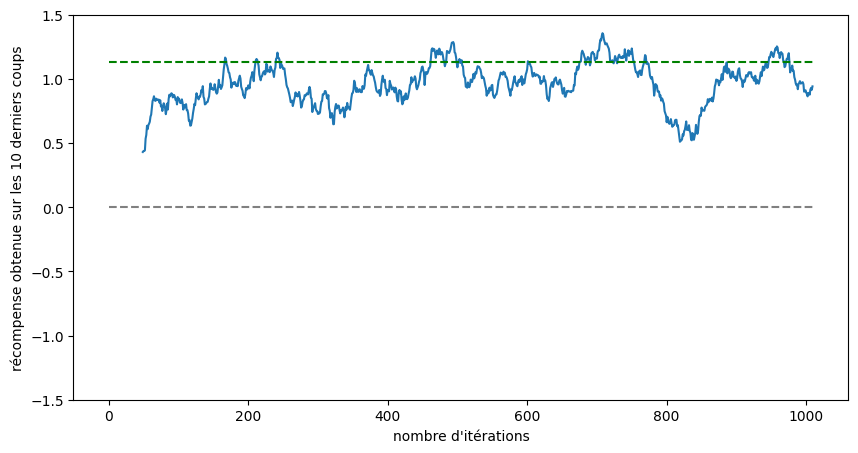

In [29]:
nb = 1000
eps = 0.1

# Initialize memory
mem = init_mem(avgs)

for i in range(nb):
    # Epsilon-greedy stratgey
    if np.random.uniform() > eps:
        # Select best action
        a = best_action(mem)
    else:
        # Select action at random
        a = np.random.choice(range(len(avgs)))
    
    # Evaluate reward
    r = reward(a, avgs)
    
    # Update memory
    mem = pd.concat(
        [
            mem,
            pd.DataFrame({
                "action": [a],
                "reward": [r]
            })
        ], ignore_index=True
    )

plot_optimal_action(mem.action, avgs)

plot_reward(mem.reward, avgs)

Sur cette unique expérience, on voit bien que la stratégie *epsilon-greedy* permet de sortir du maximum local et d'aller chercher l'action optimale (dans un grand nombre de cas).

## 2.3. Mise en oeuvre incrémentale

La mise en oeuvre actuelle nécessite de conserver une **mémoire dont la taille augmente avec les itérations**. Cela peut poser problème en pratique...

La mise en oeuvre incrémentale est en fait assez naturelle. On note $Q_t(a)$ la valeur estimée de l'action $a$ par l'algorithme après l'itération $t$ pour l'action $a$, soit :

$$Q_t(a) = \frac{R_1 + R_2 + \dots + R_{N_t(a)}}{N_t(a)},$$

avec $R_t$ la récompense obtenue à l'instant $t$ (on suppose donc au-dessus que l'action $a$ a été sélectionné aux itérations $1$ et $2$) et $N_t(a)$ le nombre de fois où l'actions $a$ a été sélectionnée après $t$ itérations.

Alors, en notant un instant $k$ et $k+1$ deux instants successifs où l'action $q$ est sélectionnée, on peut écrire :
$$
Q_{k+1} = \frac{1}{k+1} \sum_{i=1}^{k+1} R_i = Q_k + \frac{1}{k+1} \left[R_{k+1}- Q_k\right].
$$

**Ré-écrivez l'algorithme epsilon-greedy avec la formule incrémentale ci-dessous.**

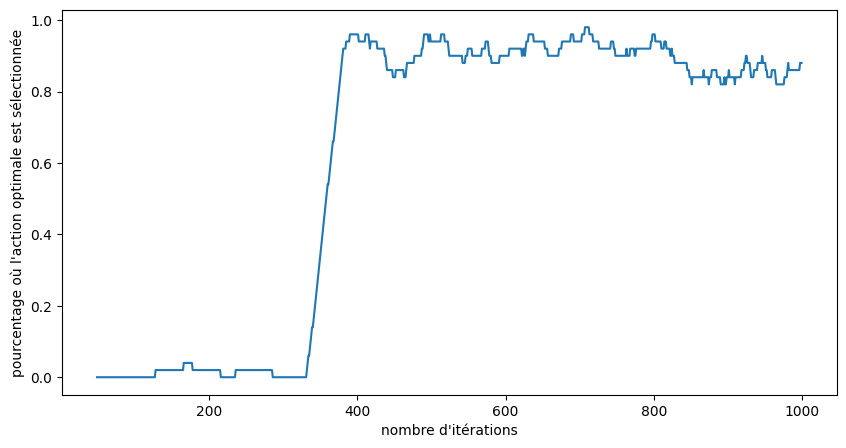

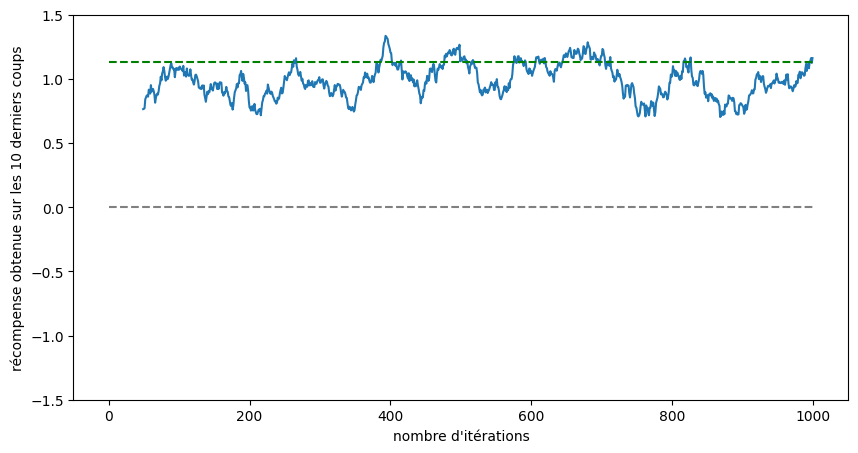

In [30]:
nb = 1000
eps = 0.1

# Initialize memory with [0, 0, ..., 0]
# These are the estimated values of our actions
init_val = 0.
Q = init_val * np.ones_like(avgs)
freq = np.ones_like(avgs)

# Store things for plotting
rewards = []
actions = []

for i in range(nb):
    # Epsilon-greedy stratgey
    if np.random.uniform() > eps:
        # Select best action
        a = np.argmax(Q)
    else:
        # Select action at random
        a = np.random.choice(range(len(avgs)))
    
    # Evaluate reward
    r = reward(a, avgs)
    
    # for plotting
    actions.append(a)
    rewards.append(r)
    
    # Update memory
    Q[a] += (1. / freq[a]) * (r - Q[a])
    freq[a] += 1

plot_optimal_action(actions, avgs)
plot_reward(rewards, avgs)

## 2.4. UCB (Upper-Confidence-Bound)

Même si elle nous oblige par construction à nous tromper parfois, **l'exploration reste nécessaire tant que l'on n'est pas sûr d'avoir trouvé l'action optimale**.

Cependant, lorsqu'on a à choisir l'action optimale étant donnée notre expérience passée, il peut être utile de considérer le fait que l'**on n'a pas exploré autant chaque option**. Les options $a$ qui ont été moins visitées ont une valeur estimée $Q(a)$ qui est plus incertaine que celles qui auront été plus visitées.

La formule UCB prend cela en compte et propose de sélectionner :

$$
A_t = \arg\max_a \left[Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \right],
$$

avec le réel (positif) $c$ qui calibre le niveau d'exploration que l'on souhaite. On peut commencer avec $c=1$.

La vision derrière UCB est de choisir l'option qui a les meilleures chances d'être la meilleure (observez le $\max$ dans la formule ci-dessous). Plus on teste une action $a$ donnée, plus on se rapproche de la simple maximisation de $Q_t(a)$ comme précédemment. **UCB est un algorithme optimiste.**

**Ecrivez 1000 itérations de l'algorithme UCB avec $c=1$.**

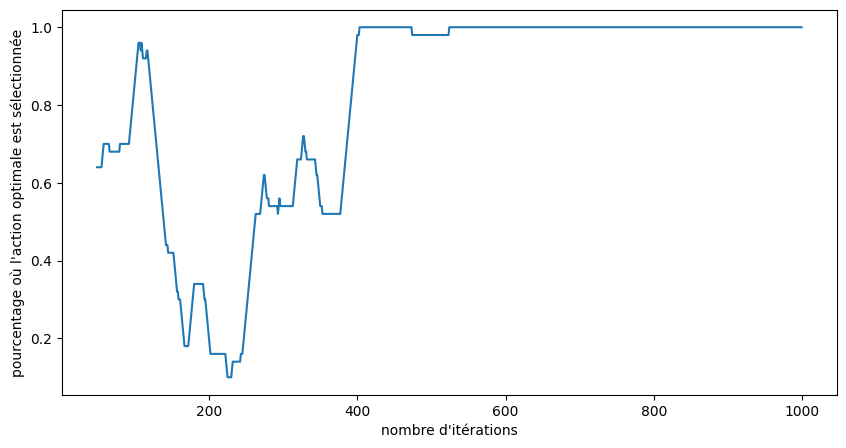

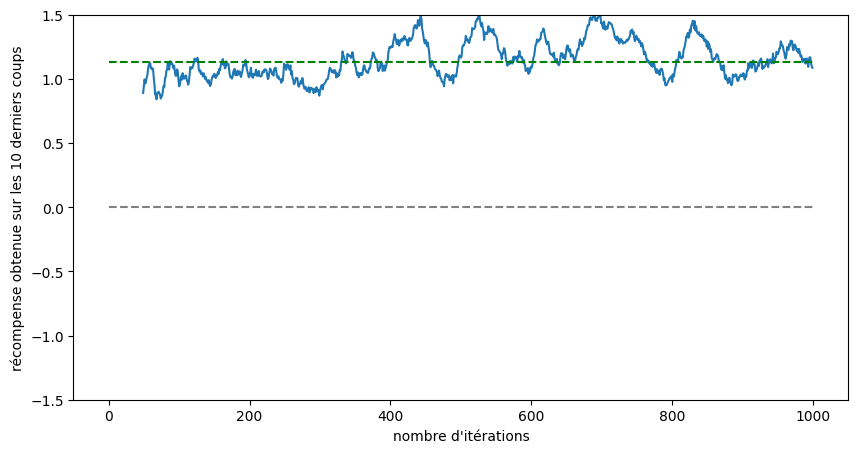

In [38]:
nb = 1000
c = 1.

# Initialize memory with [0, 0, ..., 0]
# These are the estimated values of our actions
init_val = 0.
Q = init_val * np.ones_like(avgs)
freq = np.ones_like(avgs)

# Store things for plotting
rewards = []
actions = []

for i in range(nb):
    # Select best action
    a = np.argmax(Q + c * np.sqrt(np.log(i+1) / freq))
    
    # Evaluate reward
    r = reward(a, avgs)
    
    # for plotting
    actions.append(a)
    rewards.append(r)
    
    # Update memory
    Q[a] += (1. / freq[a]) * (r - Q[a])
    freq[a] += 1

plot_optimal_action(actions, avgs)
plot_reward(rewards, avgs)

# 3. Comparaison de l'ensemble des méthodes

Comme vous avez pu le constater, **les résultats obtenus par ces algorithmes sont stochastiques**, du fait que l'environnement sur lequel ils sont testés (les bandits manchots) l'est.

**Il convient donc de les juger en tant que stochastiques, en comparant leurs moyennes (ou médianes) sur un grand nombre de tirages.**

## 3.1. Simulateur de l'environnement

Commençons par créer un objet qui va servir à simuler l'environnement. L'objet *Environment* doit permettre de :
* Initialiser un environnement en tirant au hasard les valeurs moyennes des bandits manchots,
* Faire un nouveau tirage d'un bandit manchot $k$.

**Créez une classe Environment, dont le constructeur prend en entrée le nombre $n$ de bandits manchots et définit une liste de n valeurs moyennes de bandits manchots.** La classe dispose également d'une **méthode *reward* qui tire la récompense associée à une action $a$**.

In [25]:
class Environment(object):
    def __init__(self, nb_bandits: int):
        self.nb_bandits = nb_bandits
        self.reset()
    
    def reset(self):
        """Creates the list of average values for the n-arm bandit
        """
        self.avgs = np.random.normal(size=self.nb_bandits)
        self.best_action = np.argmax(self.avgs)
    
    def reward(self, a: int):
        """Returns the reward associated with the a-th bandit
        It is a random value following the N(avgs[a], 1) law
        """
        return np.random.normal(loc=self.avgs[a])

# create a new set of arm-bandits
env = Environment(10)

# reward for bandit 0
print(env.reward(0))

# reward for bandit 4
print(env.reward(4))

-1.8392416596081524
3.5902320150586418


## 3.2. Test sur un grand nombre d'expériences

Nous allons tester les différentes méthodes rencontrées sur un grand nombre d'expériences indépendantes. Il suffira de créer à chaque fois un nouvel environnement.

A chaque "tour", nous testerons si l'algorithme décide de l'action qui est optimale.

**Simulez sur 500 expériences les performances de UCB et de epsilon-greedy (epsilon=0.1). Tirez-en un graphique où qui présente en ordonnées le pourcentage d'expériences où l'action optimale a été choisie, avec le nombre d'itérations en abscisses.**

Pour faire cela, j'ai construit une fonction `simulate` qui simule un algorithme sur un environnement, pour un nombre d'itérations (horizon de temps) et un nombre d'expériences donné. Les algorithmes sont représentés par des classes Python.

In [26]:
def simulate(env, alg, nb_experiments=100, T=1000):
    """Simulates evolution of the env Environment using the alg Learner/Algoritm
    """
    optimal_actions = np.ndarray(shape=(T, nb_experiments))

    for n in range(nb_experiments):
        # initialize bandits
        env.reset()

        # initialize learners
        alg.reset()

        for t in range(T):
            # Select best action
            a = alg.select_action()

            # Evaluate reward
            r = env.reward(a)

            # for comparison purposes
            optimal_actions[t, n] = (a == env.best_action)

            # Update memory
            alg.update(a, r)
        
    return optimal_actions

In [27]:
class UCB(object):
    """Implements the Upper-Confidence-Bound algorithm
    """
    def __init__(self, nb_bandits: int, c: float = 1., init_val: float = 0.):
        self.nb_bandits = nb_bandits
        self.c = c
        self.init_val = init_val
        
        self.reset()
    
    def reset(self):
        # Initialize memory with [0, 0, ..., 0]
        # These are the estimated values of our actions
        self.Q = self.init_val * np.ones(self.nb_bandits)
        self.freq = np.ones(self.nb_bandits)
        self.i = 0
    
    def select_action(self):
        """Selects best current action according to UCB rule
        """
        return np.argmax(self.Q + self.c * np.sqrt(np.log(self.i+1) / self.freq))
    
    def update(self, a: int, r: float):
        """Updates algorithm "memory" parameters
        """
        self.Q[a] += (1. / self.freq[a]) * (r - self.Q[a])
        self.freq[a] += 1
        self.i += 1

In [28]:
class EpsilonGreedy(object):
    """Implements the epsilon-greedy algorithm
    """
    def __init__(self, nb_bandits: int, eps: float = 0.1):
        self.nb_bandits = nb_bandits
        self.eps = eps
        
        self.reset()
    
    def reset(self):
        # Initialize memory with [0, 0, ..., 0]
        # These are the estimated values of our actions
        self.Q = np.zeros(self.nb_bandits)
        self.freq = np.ones(self.nb_bandits)
    
    def select_action(self):
        """Selects best current action
        """
        if self.eps < np.random.uniform():
            return np.argmax(self.Q)
        else:
            return np.random.randint(0, self.nb_bandits)
    
    def update(self, a: int, r: float):
        """Updates algorithm "memory" parameters
        """
        self.Q[a] += (1. / self.freq[a]) * (r - self.Q[a])
        self.freq[a] += 1

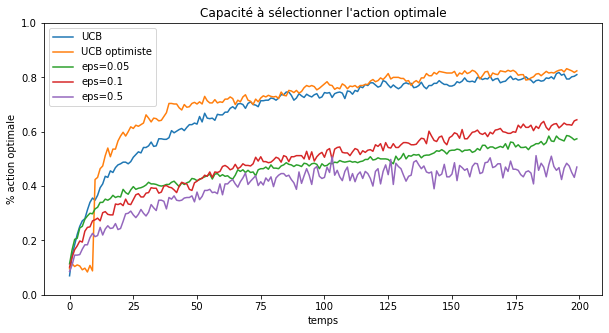

In [29]:
nb_bandits = 10

plt.figure(figsize=(10, 5))

for alg, name in [
    (UCB(nb_bandits), "UCB"),
    (UCB(nb_bandits, init_val=5.0), "UCB optimiste"),
    (EpsilonGreedy(nb_bandits, eps=0.05), "eps=0.05"),
    (EpsilonGreedy(nb_bandits, eps=0.1), "eps=0.1"),
    (EpsilonGreedy(nb_bandits, eps=0.5), "eps=0.5"),
]:
    optimal_actions = simulate(Environment(nb_bandits), alg, nb_experiments=500, T=200)
    plt.plot(optimal_actions.mean(axis=1), label=name)

plt.xlabel("temps")
plt.ylabel("% action optimale")
plt.ylim(0, 1)
plt.title("Capacité à sélectionner l'action optimale")
plt.legend()
plt.show()